# 02. Neural Network Classificaiton with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

In [32]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [33]:
torch.__version__

'2.4.1+cu121'

## 1. Data

In [34]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [35]:
len(X), len(y)

(1000, 1000)

In [36]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [37]:
# Exploring the data
circles_df = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "label": y})

circles_df

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


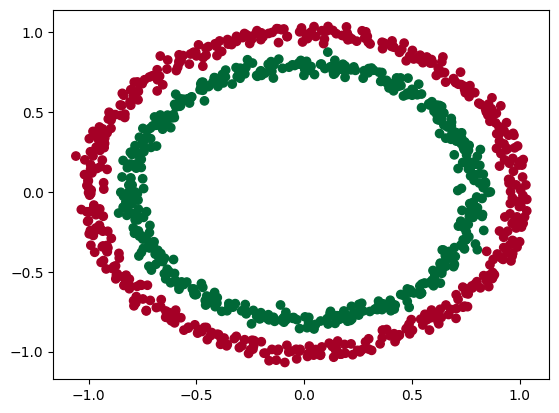

In [38]:
# Visualize circles
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlGn);

**Note:** The data we're working with is oftern referred to as a toy dataset, once it's small enough to experiment on, but still sizeable enough to practise.

### 1.1 Check input and output shapes

In [39]:
X.shape, y.shape

((1000, 2), (1000,))

In [40]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values of sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values of sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors

In [41]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float) # Default PyTorch datatype

In [42]:
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

### 1.3 Split the data

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Build a model

1. Setup device agnostic code (GPU)
2. Construct a model (nn.Module)
3. Define a loss function and optimizer
4. Create training and test loop

### 1. Setup device agnostic code

In [44]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 2. Construct a model

In [45]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Creating two layers
    self.linear_layer_1 = nn.Linear(in_features=2,
                                    out_features=16) # Usually we use multiples of 8, the more out features, more numbers for learning patterns.
    self.linear_layer_2 = nn.Linear(in_features=16, # Must match the past layer out features.
                                    out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_2(self.linear_layer_1(x))

In [46]:
model_0 = CircleModelV0().to(device)
model_0, model_0.state_dict()

(CircleModelV0(
   (linear_layer_1): Linear(in_features=2, out_features=16, bias=True)
   (linear_layer_2): Linear(in_features=16, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802],
                       [-0.3258, -0.0829],
                       [-0.2872,  0.4691],
                       [-0.5582, -0.3260],
                       [-0.1997, -0.4252],
                       [ 0.0667, -0.6984],
                       [ 0.6386, -0.6007]])),
              ('linear_layer_1.bias',
               tensor([ 0.5459,  0.1177, -0.2296,  0.4370,  0.1102,  

### 2.0 Using nn.Sequential

In [47]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0, model_0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[-0.1473,  0.5865],
                       [-0.4191, -0.4217],
                       [-0.4217,  0.6360],
                       [ 0.2356,  0.6804],
                       [-0.5836, -0.7014]])),
              ('0.bias',
               tensor([-0.5532, -0.4757,  0.2864,  0.2532,  0.5876])),
              ('1.weight',
               tensor([[-0.2310, -0.3049,  0.2373, -0.1808,  0.2714]])),
              ('1.bias', tensor([-0.1061]))]))

In [48]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
  print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
  print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

**Loss function:**
* Classification - Binary cross entropy or categorical cross entropy
* Regression - MAE or MSE (mean absolute error or mean squared error)

**Optimizer:**
* SGD
* Adam

In [49]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built-in (used for binary classification)

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [50]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

## 3. Train model

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

1. Our model outputs are going to be raw **logits**.
2. Using an activation function we can convert these **logits** into **prediction probabilities**.
3. Convert our model's **prediction probabilities** to **prediction labels** by either rounding them or taking the `argmax()`.

**Types of activation functions**
* Sigmoid - For binary crossentropy.
* Softmax - For multiclass classification.

#### Logits

In [51]:
# Output of the forward pass (logits)
model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2850],
        [0.1836],
        [0.4995],
        [0.2244],
        [0.4182]])

#### Prediction probabilities (using sigmoid activation function)

In [52]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5708],
        [0.5458],
        [0.6223],
        [0.5559],
        [0.6031]])

#### Prediction labels (rounding values)

We need to perform a range-style rounding on the prediction probability values.
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [53]:
y_preds = torch.round(y_pred_probs)

# Entire process (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Equality check
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True])


### 3.2 Build a training and test loop

In [54]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [55]:
torch.manual_seed(42)

epochs = 2000

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Loss and accuracy
  loss = loss_fn(y_logits, # Expect raw logits as input (BCEWithLogitsLoss)
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))


    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss} | Train accuracy: {acc} | Test accuracy: {test_acc}")

Epoch: 0 | Train loss: 0.7120756506919861 | Test loss: 0.7031487226486206 | Train accuracy: 50.0 | Test accuracy: 50.0
Epoch: 100 | Train loss: 0.6930654644966125 | Test loss: 0.6939490437507629 | Train accuracy: 50.375 | Test accuracy: 48.0
Epoch: 200 | Train loss: 0.6929910778999329 | Test loss: 0.6945414543151855 | Train accuracy: 50.875 | Test accuracy: 47.5
Epoch: 300 | Train loss: 0.6929818987846375 | Test loss: 0.6946403384208679 | Train accuracy: 51.24999999999999 | Test accuracy: 46.5
Epoch: 400 | Train loss: 0.692980170249939 | Test loss: 0.6946648955345154 | Train accuracy: 51.37500000000001 | Test accuracy: 46.0
Epoch: 500 | Train loss: 0.6929798722267151 | Test loss: 0.6946735978126526 | Train accuracy: 51.37500000000001 | Test accuracy: 44.5
Epoch: 600 | Train loss: 0.6929798126220703 | Test loss: 0.6946770548820496 | Train accuracy: 51.37500000000001 | Test accuracy: 45.0
Epoch: 700 | Train loss: 0.6929798722267151 | Test loss: 0.6946784853935242 | Train accuracy: 51.125

## 4. Make predictions and evaluate the model

Given the results above it seems that our model isn't learning anything.

In [56]:
import requests
from pathlib import Path

# Download helper functions
if Path("helper_functions.py").is_file():
  print("Exists")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Exists


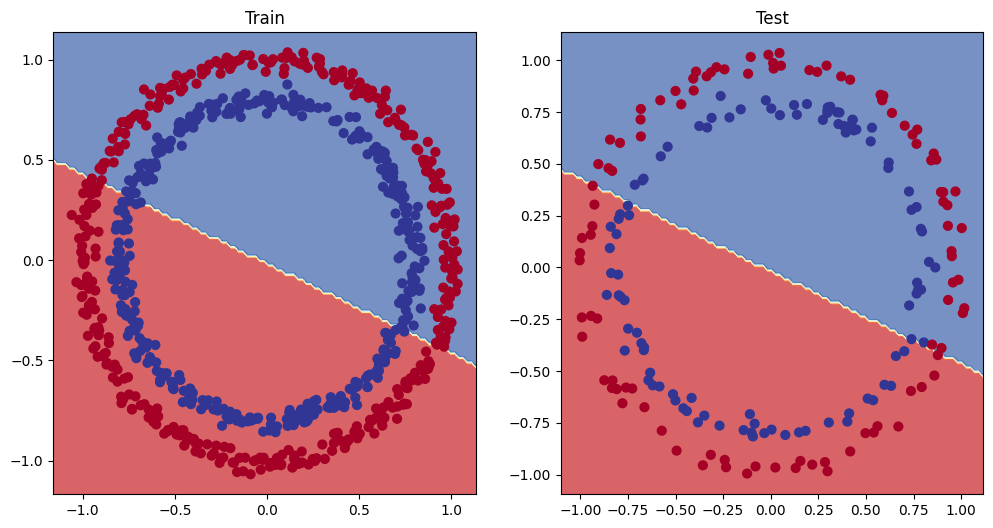

In [57]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

These are the hyperparameters that we can change:
* Add more layers - Give the model more changes to learn about patterns in the data.
* Add more hidden units (neurons) - Give the more parameters so it can learn more about the data.
* Fit longer - Add more epochs.
* Changing the activation function.
* Change the learning rate.
* Change the loss function.

### First experiment

* Adding more units, number of layers and epochs

In [58]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=24)
    self.layer_2 = nn.Linear(in_features=24, out_features=24)
    self.layer_3 = nn.Linear(in_features=24, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [59]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=24, bias=True)
  (layer_2): Linear(in_features=24, out_features=24, bias=True)
  (layer_3): Linear(in_features=24, out_features=1, bias=True)
)

In [60]:
# loss_fn
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [62]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 10000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_test,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(y_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 1000 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss} | Train accuracy: {acc} | Test accuracy: {test_acc}")

RuntimeError: The size of tensor a (2) must match the size of tensor b (800) at non-singleton dimension 1